In [22]:
import numpy as np
from qm.qua import *
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from qualang_tools.units import unit
u = unit(coerce_to_integer=True)
from qm import QuantumMachinesManager
import os
import config_00 as config
import importlib

In [23]:
import QM_cluster
qmm = QuantumMachinesManager(host=QM_cluster.QM_Router_IP, cluster_name=QM_cluster.cluster_name, log_level="ERROR", octave_calibration_db_path=os.getcwd()) 

In [26]:
importlib.reload(config)
qm = qmm.open_qm(config.config)
print(f'QM is ready with id {qm.id}')

QM is ready with id qm-1697706038206


/tmp/ipykernel_63681/1988545544.py:11: DeprecationWarning: Saving an adc stream now requires defining it at the end of the measure command with the `adc_stream` argument, e.g. `adc_stream=adc_st`. The current syntax is deprecated and will be removed in a 1.3.
  measure("readout", "scope", adc_st)


DC offset to add to I: -0.000114 V
DC offset to add to Q: 0.000082 V
TOF to add: 0.0 ns
Copy the following line


NameError: name 'gain_db_opx' is not defined

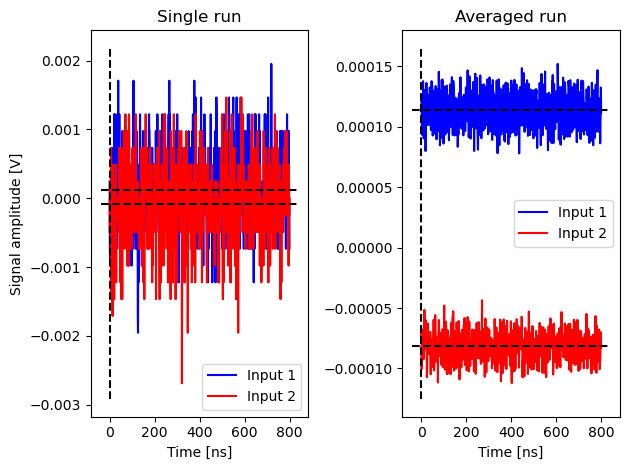

In [28]:
n_avg = 5000  # Number of averaging loops
cooldown_time = 2 * u.us  # readout cooldown time

with program() as qm_program:
    n = declare(int)
    adc_st = declare_stream(adc_trace=True)

  
    with for_(n, 0, n < n_avg, n + 1):
        reset_if_phase("scope")
        measure("readout", "scope", adc_st)
        wait(cooldown_time, "scope")

    with stream_processing():
        # Will save average:
        adc_st.input1().average().save("adc1")
        adc_st.input2().average().save("adc2")
        # # Will save only last run:
        adc_st.input1().save("adc1_single_run")
        adc_st.input2().save("adc2_single_run")


# Start the job on the QM
job = qm.execute(qm_program)
res_handles = job.result_handles
fig,ax = plt.subplots(1,2)

#main
res_handles.wait_for_all_values()
adc1 = u.raw2volts(res_handles.get("adc1").fetch_all())
adc2 = u.raw2volts(res_handles.get("adc2").fetch_all())
adc1_single_run = u.raw2volts(res_handles.get("adc1_single_run").fetch_all())
adc2_single_run = u.raw2volts(res_handles.get("adc2_single_run").fetch_all())

adc1_mean = np.mean(adc1)
adc2_mean = np.mean(adc2)
adc1_unbiased = adc1 - np.mean(adc1)
adc2_unbiased = adc2 - np.mean(adc2)
signal = savgol_filter(np.abs(adc1_unbiased + 1j * adc2_unbiased), 11, 3)
# detect arrival of readout signal
th = (np.mean(signal[:100]) + np.mean(signal[:-100])) / 2
delay = np.where(signal > th)[0][0]
delay = np.round(delay / 4) * 4
dc_offset_i = -adc1_mean
dc_offset_q = -adc2_mean
# Plot data
ax[0].set_title("Single run")
ax[0].plot(adc1_single_run, "b", label="Input 1")
ax[0].plot(adc2_single_run, "r", label="Input 2")
xl = ax[0].get_xlim()
yl = ax[0].get_ylim()
ax[0].plot(xl, adc1_mean * np.ones(2), "k--")
ax[0].plot(xl, adc2_mean * np.ones(2), "k--")
ax[0].plot(delay * np.ones(2), yl, "k--")
ax[0].set_xlabel("Time [ns]")
ax[0].set_ylabel("Signal amplitude [V]")
ax[0].legend()
ax[1].set_title("Averaged run")
ax[1].plot(adc1, "b", label="Input 1")
ax[1].plot(adc2, "r", label="Input 2")
xl = ax[1].get_xlim()
yl = ax[1].get_ylim()
ax[1].plot(xl, adc1_mean * np.ones(2), "k--")
ax[1].plot(xl, adc2_mean * np.ones(2), "k--")
ax[1].plot(delay * np.ones(2), yl, "k--")
ax[1].set_xlabel("Time [ns]")
ax[1].legend()
fig.tight_layout()
#draw

# Print the analysis
print(f"DC offset to add to I: {dc_offset_i:.6f} V")
print(f"DC offset to add to Q: {dc_offset_q:.6f} V")
print(f"TOF to add: {delay} ns")
